# End to end Machine Learning Project to predict median house values in California Districts.


##### The task is to predict median house values in Californian districts, given a number of features from these districts.

The first task you are asked to perform is to build a model of housing prices in California using the California census data. This data has metrics such as the population, median income, median housing price, and so on for each block group in California

In [1]:
import pandas as pd
import sklearn
import numpy as np

In [2]:
cali_houses = pd.read_csv('../input/housing.csv')

Let's take a look at the first few rows

In [3]:
cali_houses.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


Let's see some information about the features

In [4]:
cali_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null int64
total_rooms           20640 non-null int64
total_bedrooms        20433 non-null float64
population            20640 non-null int64
households            20640 non-null int64
median_income         20640 non-null float64
median_house_value    20640 non-null int64
ocean_proximity       20640 non-null object
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


#### The info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null value.

There are 20,640 rows in the dataset. Notice that the total_bedrooms has only 20,433 nonnull values, meaning that 207 districts are missing this feature. All attributes are numerical, except the ocean_proximity field. Its type is object, so it could hold any kind of Python object, but since you loaded this data from a CSV file you know that it must be a text feature. When you looked at the top five rows, you probably noticed that the values in the ocean_proximity column were repetitive(nearbay), which means that it is probably a categorical feature. You can find out what categories exist and how many districts belong to each category by using the value_count method:

In [5]:
cali_houses["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
cali_houses.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are ignored (so, for example, count of total_bedrooms is 20,433, not 20,640). The std row shows the standard deviation, which measures how dispersed the values are. The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations falls. For example, 25% of the districts have a housing_median_age lower than 18, while 50% are lower than 29 and 75% are lower than 37. These are often called the 25th percentile (or 1st quartile), the median, and the 75th percentile (or 3rd quartile).

Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical feature. A histogram shows the number of rows (on the vertical axis) that have a given value range (on the horizontal axis). You can either plot this one feature at a time, or you can call the hist() method on the whole dataset, and it will plot a histogram for each numerical feature.

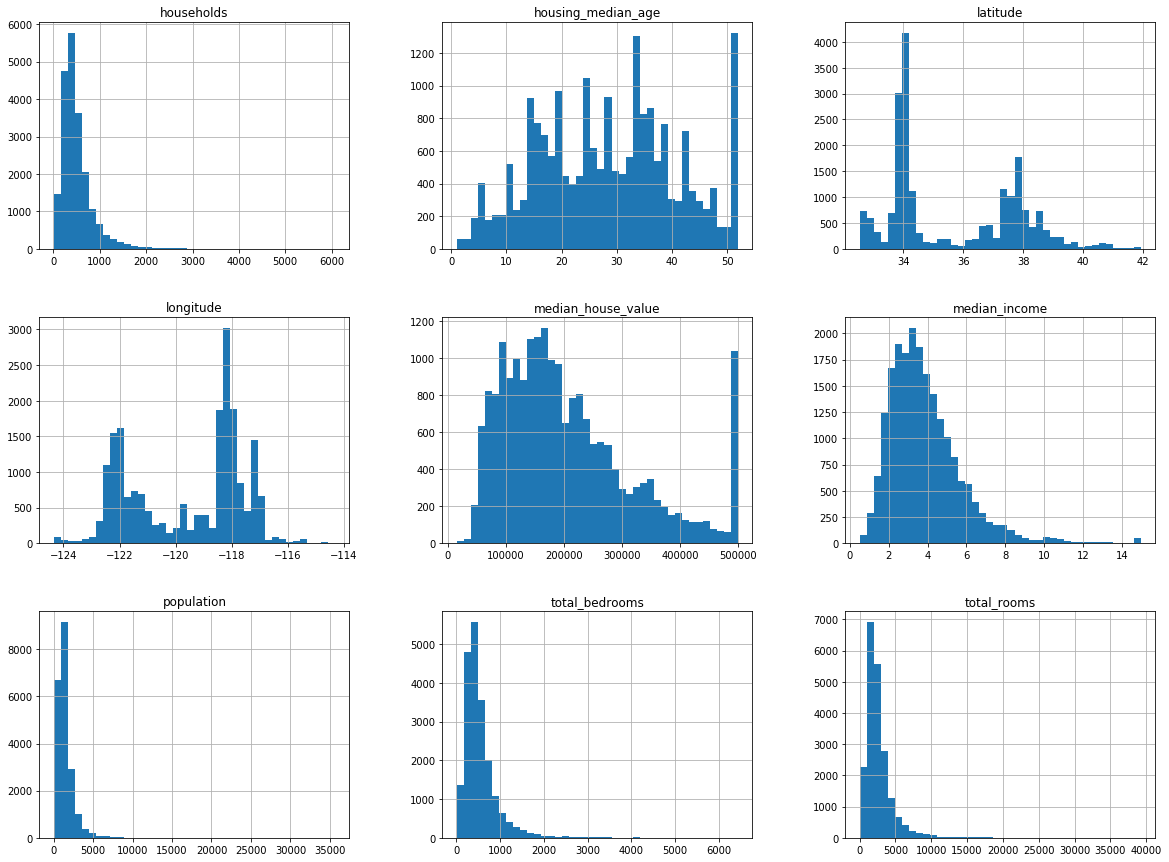

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt 
cali_houses.hist(bins=40, figsize=(20,15))
plt.show()

### Is there anything that might look strange in these histograms?

The housing median age and the median house value has a big bar at the end. We can make a guess that the housing median age is capped at 50 and the median house value is capped at 500,000. We have to confirm with the team that gave us this data. 

## Creating a Test set.

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split. First there is a random state parameter that allows you to set the random generator seed and second you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices.

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(cali_houses, test_size=0.2, random_state=34)

##  significant features

After looking at the data I can see that the median income is a very important attribute to predict median housing prices. We may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, We first need to create an income category attribute. Most median income values are clustered around 20,000–50,000, but some median incomes go far beyond 60,000. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5.

In [9]:
cali_houses["income_cat"] = np.ceil(cali_houses["median_income"] / 1.5)
cali_houses["income_cat"].where(cali_houses["income_cat"] < 5, 5.0, inplace=True)

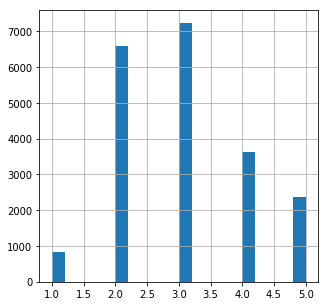

In [10]:
cali_houses["income_cat"].hist(bins=20, figsize=(5,5))
plt.show()

##### Now you are ready to do stratified sampling based on the income category. For this you can use ScikitLearn’s StratifiedShuffleSplit class:

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=34) 
for train_index, test_index in split.split(cali_houses, cali_houses["income_cat"]):
    strat_train_set = cali_houses.loc[train_index]
    strat_test_set = cali_houses.loc[test_index]

##### Let’s see if this worked as expected. You can start by looking at the income category proportions in the full housing dataset

In [12]:
cali_houses["income_cat"].value_counts() / len(cali_houses)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

With similar code you can measure the income category proportions in the test set. The test set generated stratified sampling should have income category proportions almost identical to those in the full dataset. 

##### Now you should remove the income_cat attribute so the data is back to its original state

In [13]:
for set_ in (strat_train_set, strat_test_set): 
    set_.drop("income_cat", axis=1, inplace=True)

##### We spent quite a bit of time on test set generation for a good reason: this is an often neglected but critical part of a Machine Learning project

## Exploring the Data

First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so you can just work directly on the full set. Let’s create a copy so you
can play with it without harming the training set:

In [14]:
cali_houses = strat_train_set.copy()

##### Visualizing Geographical Dat

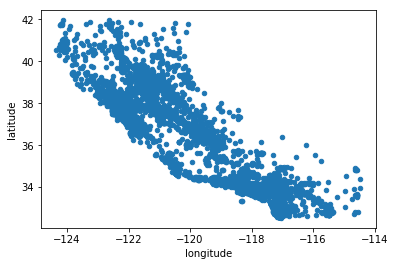

In [15]:
cali_houses.plot(kind="scatter", x="longitude", y="latitude")

This looks like California all right, but other than that it is hard to see any particular pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points. 

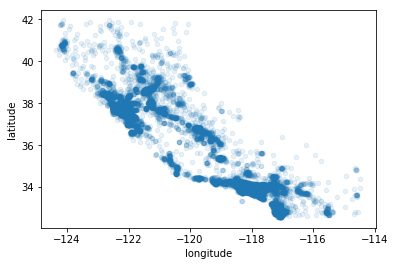

In [16]:
cali_houses.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

We can now see the high-density areas, namely the Bay Area and around Los Angeles and San Diego.

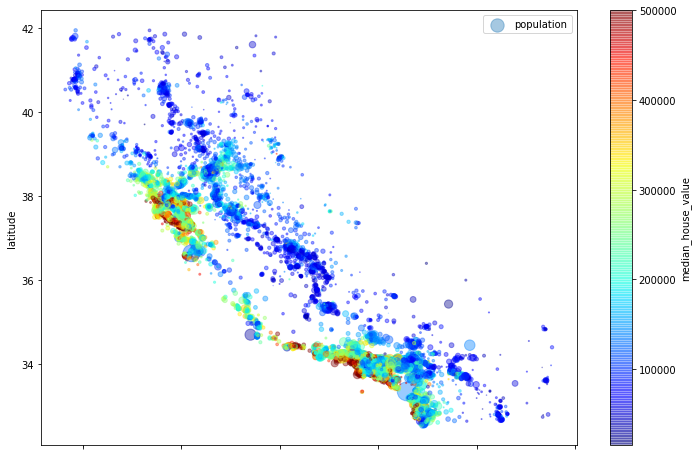

In [17]:
cali_houses.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=cali_houses["population"]/100, label="population", figsize=(12,8), 
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

This image tells you that the housing prices are related to the location and to the population density

## Correlations

We can compute the standard correlation coefficient between every pair of attributes using the corr() method

In [18]:
corr_matrix = cali_houses.corr()

In [19]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690030
total_rooms           0.141673
housing_median_age    0.108334
households            0.072509
total_bedrooms        0.056041
population           -0.020023
longitude            -0.046017
latitude             -0.144008
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to zero mean that there is no linear correlation.

Another way to check for correlation between attributes is to use Pandas’ scatter_matrix function, which plots every numerical attribute against every other numerical attribute. So let’s focus on a few promising attributes that seem most correlated with the median housing value.

In [20]:
import pandas.plotting

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f098c95b6d8>,
      dtype=object)

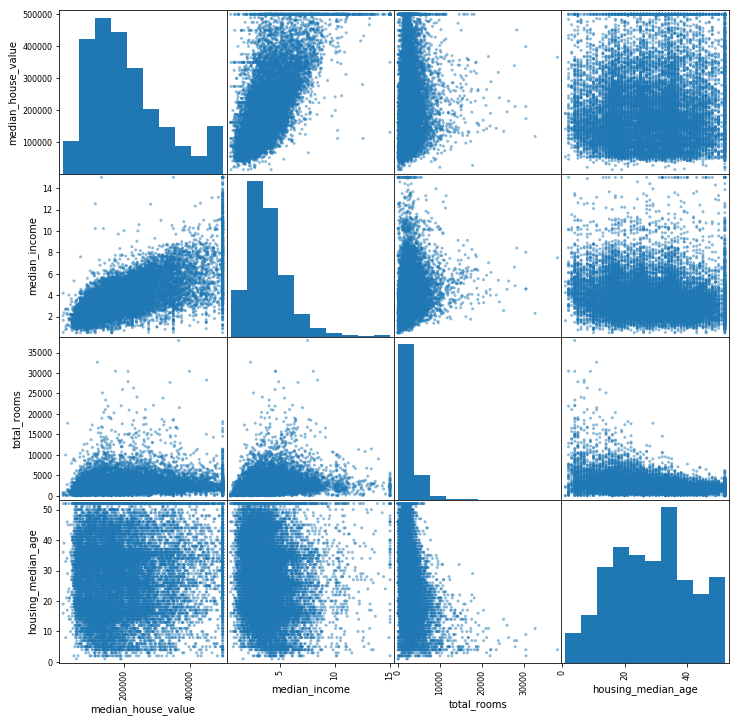

In [21]:
from pandas.plotting import scatter_matrix 
features = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(cali_houses[features], figsize=(12, 12))

We already know that the most important feature to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot.

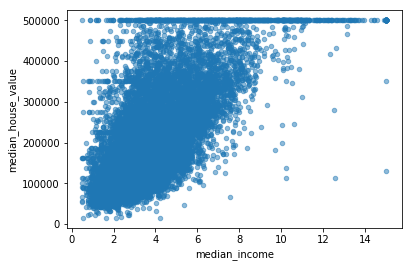

In [22]:
cali_houses.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.5)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000.

### Combining Features

We identified a few data insights that we may want to clean up before feeding the data to a Machine Learning algorithm, and we found interesting correlations between features, in particular with the target featur. One last thing we may want to do before actually preparing the data for Machine Learning algorithms is to try out various feature combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting feature combination to look at. Let’s create these new features

In [23]:
cali_houses["rooms_per_household"] = cali_houses["total_rooms"]/cali_houses["households"]
cali_houses["bedrooms_per_room"] = cali_houses["total_bedrooms"]/cali_houses["total_rooms"]
cali_houses["population_per_household"]=cali_houses["population"]/cali_houses["households"]

In [24]:
corr_matrix = cali_houses.corr() 
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690030
rooms_per_household         0.156706
total_rooms                 0.141673
housing_median_age          0.108334
households                  0.072509
total_bedrooms              0.056041
population                 -0.020023
population_per_household   -0.020612
longitude                  -0.046017
latitude                   -0.144008
bedrooms_per_room          -0.259533
Name: median_house_value, dtype: float64

As we can see the new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district — obviously the larger the houses, the more expensive they are.

## Preparing the Data

But first let’s revert to a clean training set (by copying strat_train_set once again), and let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set)

In [25]:
cali_houses = strat_train_set.drop("median_house_value", axis=1)
cali_houses_labels = strat_train_set["median_house_value"].copy()

In [26]:
sample_incomplete_rows = cali_houses[cali_houses.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5723,-118.23,34.18,45,2332,NaN,943,339,8.1132,<1H OCEAN
18873,-122.22,38.08,37,2811,NaN,1574,516,3.1053,NEAR BAY
13015,-121.19,38.71,11,4415,NaN,1520,627,3.2321,INLAND
19485,-120.98,37.66,10,934,NaN,401,255,0.9336,INLAND
7330,-118.17,33.98,41,756,NaN,873,212,2.7321,<1H OCEAN


### Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. We saw earlier that the total_bedrooms feature has some missing values, so let’s fix this

We will Set the missing values to some value (zero, the mean, the median, etc.), In our case we will set to the median value

In [27]:
median = cali_houses["total_bedrooms"].median() 
cali_houses["total_bedrooms"].fillna(median, inplace=True)

Scikit-Learn provides a handy class to take care of missing values: Imputer. Here is how to use it. First, we need to create an Imputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute

In [28]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity

In [29]:
cali_houses_num =cali_houses.drop("ocean_proximity", axis=1)

Now you can fit the imputer instance to the training data using the fit() method:

In [30]:
imputer.fit(cali_houses_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable.

In [31]:
imputer.statistics_

array([-118.515  ,   34.26   ,   29.     , 2119.5    ,  433.     ,
       1159.5    ,  408.     ,    3.53545])


Check that this is the same as manually computing the median of each feature:

In [32]:
cali_houses_num.median().values

array([-118.515  ,   34.26   ,   29.     , 2119.5    ,  433.     ,
       1159.5    ,  408.     ,    3.53545])

Now we can use this “trained” imputer to transform the training set by replacing missing values by the learned medians

In [33]:
X = imputer.transform(cali_houses_num)

The result is a plain Numpy array containing the transformed features. If we want to put it back into a Pandas DataFrame, it’s simple

In [34]:
cali_houses_tr = pd.DataFrame(X, columns=cali_houses_num.columns,
                          index = list(cali_houses.index.values))


Let's take a look at our sample now

In [35]:
cali_houses_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
5723,-118.23,34.18,45.0,2332.0,433.0,943.0,339.0,8.1132
18873,-122.22,38.08,37.0,2811.0,433.0,1574.0,516.0,3.1053
13015,-121.19,38.71,11.0,4415.0,433.0,1520.0,627.0,3.2321
19485,-120.98,37.66,10.0,934.0,433.0,401.0,255.0,0.9336
7330,-118.17,33.98,41.0,756.0,433.0,873.0,212.0,2.7321


### Handling Text and Categorical features

We left out the categorical feature ocean_proximity because it is a text feature so we cannot compute its median. Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these text labels to numbers.

Now let's preprocess the categorical input feature, ocean_proximity:

In [36]:
cali_houses_cat = cali_houses[['ocean_proximity']]
cali_houses_cat.head(10)

,ocean_proximity
13220,INLAND
11356,<1H OCEAN
1318,INLAND
14422,NEAR OCEAN
3474,<1H OCEAN
14677,<1H OCEAN
18695,INLAND
19762,INLAND
5714,<1H OCEAN
19546,INLAND


In [37]:
from sklearn.preprocessing import OrdinalEncoder

In [38]:
ordinal_encoder = OrdinalEncoder()
cali_houses_cat_encoded = ordinal_encoder.fit_transform(cali_houses_cat)
cali_houses_cat_encoded[:10]

array([[1.],
       [0.],
       [1.],
       [4.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [39]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. Obviously this is not the case (for example, categories 0 and 4 are more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). 

Scikit-Learn provides a OneHotEncoder encoder to convert integer categorical values into one-hot vectors. Let’s encode the categories as one-hot vectors. Note that fit_transform() expects a 2D array, but cali_houses_cat_encoded is a 1D array, so we need to reshape it:

In [40]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder() 
cali_houses_cat_1hot = cat_encoder.fit_transform(cali_houses_cat)
cali_houses_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>


By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by calling the toarray() method:

In [41]:
cali_houses_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

Alternatively, you can set sparse=False when creating the OneHotEncoder:

In [42]:
cat_encoder = OneHotEncoder(sparse=False)
cali_houses_cat_1hot = cat_encoder.fit_transform(cali_houses_cat)
cali_houses_cat_1hot

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [43]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
cali_houses.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

Let's create a custom transformer to add extra features:

We can use Scikit-Learn's FunctionTransformer class that lets you easily create a transformer based on a transformation function.

In [45]:

from sklearn.base import BaseEstimator, TransformerMixin


rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(cali_houses.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
cali_houses_extra_attribs = attr_adder.fit_transform(cali_houses.values)

In [46]:
cali_houses_extra_attribs = pd.DataFrame(
    cali_houses_extra_attribs,
    columns=list(cali_houses.columns)+["rooms_per_household", "population_per_household"])
cali_houses_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-117.7,34,15,4905,711,2711,762,5.7021,INLAND,6.43701,3.55774
1,-117.93,33.74,30,1654,434,1843,467,3.1403,<1H OCEAN,3.54176,3.94647
2,-121.77,37.99,4,5623,780,2429,716,5.4409,INLAND,7.85335,3.39246
3,-117.23,32.8,27,1297,355,776,337,2.4643,NEAR OCEAN,3.84866,2.30267
4,-118.49,34.28,31,3508,585,1957,588,6.6458,<1H OCEAN,5.96599,3.32823


## Feature Scaling


One of the most important transformations you need to apply to your data is feature scaling. For the most part, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. 

Note that scaling the target values is generally not required. There are two common ways to get all features to have the same scale: min-max scaling and standardization. Min-max scaling (many people call this normalization) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. 

Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if you don’t want 0–1 for some reason. 

Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the variance so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. 

Scikit-Learn provides a transformer called StandardScaler for standardization

## Transformation Pipelines

 
Now let's build a pipeline for preprocessing the numerical features

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

cali_houses_num_tr = num_pipeline.fit_transform(cali_houses_num)

In [48]:
cali_houses_num_tr

array([[ 0.93565666, -0.76635298, -1.09020201, ...,  0.43473772,
         0.04830387, -1.03982401],
       [ 0.82115863, -0.88792586,  0.10305632, ..., -0.81134403,
         0.08538866,  0.73745211],
       [-1.09046066,  1.09932309, -1.96525811, ...,  1.04431524,
         0.03253549, -1.13422875],
       ...,
       [-1.14522059,  0.76733562,  0.34170798, ...,  0.10209066,
        -0.05526133, -0.52063784],
       [ 0.73652965, -0.8084359 ,  0.58035965, ...,  0.06787821,
         0.0684801 ,  5.79240352],
       [ 0.8858749 , -0.83649118, -1.01065145, ...,  0.62217544,
        -0.04502465, -0.91114606]])

The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a StandardScaler, which is a transformer, so the pipeline has a transform() method that applies all the transforms to the data in sequence (it also has a fit_transform method that we could have used instead
of calling fit() and then transform())

In [49]:
from sklearn.compose import ColumnTransformer

In [50]:

num_attribs = list(cali_houses_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

cali_houses_prepared = full_pipeline.fit_transform(cali_houses)

In [51]:
cali_houses_prepared

array([[ 0.93565666, -0.76635298, -1.09020201, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82115863, -0.88792586,  0.10305632, ...,  0.        ,
         0.        ,  0.        ],
       [-1.09046066,  1.09932309, -1.96525811, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.14522059,  0.76733562,  0.34170798, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.73652965, -0.8084359 ,  0.58035965, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8858749 , -0.83649118, -1.01065145, ...,  0.        ,
         0.        ,  0.        ]])

In [52]:
cali_houses_prepared.shape

(16512, 16)

## Select and Train a Model

Let’s train a regression Model

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(cali_houses_prepared, cali_houses_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Now we have a working Linear Regression model. Let’s try it out on a few instances from the training set

let's try the full preprocessing pipeline on a few training instances

In [54]:

some_data = cali_houses.iloc[:5]
some_labels = cali_houses_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [203125.64090742 176400.9692589  197267.4479793  184068.96737146
 319543.66262316]


Compare against the actual values:

In [55]:
print("Labels:", list(some_labels))

Labels: [193100, 153000, 205100, 244400, 285500]


It works, although the predictions are not exactly accurate. Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error function

In [56]:
from sklearn.metrics import mean_squared_error

cali_houses_predictions = lin_reg.predict(cali_houses_prepared)
lin_mse = mean_squared_error(cali_houses_labels, cali_houses_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68339.51656641728

Okay, this is better than nothing but clearly not a great score: most districts’ median_housing_values range between  120,000 and  265,000, so a typical prediction error of $68,628 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data

In [57]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(cali_houses_prepared, cali_houses_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [58]:
cali_houses_predictions = tree_reg.predict(cali_houses_prepared)
tree_mse = mean_squared_error(cali_houses_labels, cali_houses_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It is much more likely that the model has badly overfit the data. How can we be sure? As we saw earlier, We don’t want to touch the test set until you we ready to launch a model we are confident about, so we need to use part of the training set for training, and part for model validation.

A great alternative is to use Scikit-Learn’s cross-validation feature. The following code performs K-fold cross-validation: it randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [59]:

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, cali_houses_prepared, cali_houses_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [60]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [67778.32421717 74336.97342724 71855.82093064 71560.37805492
 68414.31595284 72590.01608384 67976.60989688 68445.37638121
 70800.64336109 72583.25875856]
Mean: 70634.17170643878
Standard deviation: 2205.6765443667823


Now the Decision Tree doesn’t look as good as it did earlier, Notice that cross-validation allows we to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately 71,052, generally ±1714, We would not have this information if you just used one validation set.

Let’s try another model now: the RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further.

In [61]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(cali_houses_prepared, cali_houses_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [62]:
cali_houses_predictions = forest_reg.predict(cali_houses_prepared)
forest_mse = mean_squared_error(cali_houses_labels, cali_houses_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22255.52843068718

In [63]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, cali_houses_prepared, cali_houses_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [50670.50633926 55935.91666639 52851.97080451 53044.48277925
 53185.30843456 52318.18038136 50370.65117905 48432.76911539
 55970.7107385  53718.28206468]
Mean: 52649.877850295175
Standard deviation: 2246.2752580841297


## Fine Tune Your Model

Scikit-Learn’s GridSearchCV search for hyperparameters good combination. All you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
   
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(cali_houses_prepared, cali_houses_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor hyperparameter values, and it will train each model five times (since we are using five-fold cross validation). In other words there will be 18 × 5 = 90 rounds of training! It may take quite a long time, but when it is done you can get the best combination of parameters like this:

In [65]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [66]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [67]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63748.365823259686 {'max_features': 2, 'n_estimators': 3}
55127.86203486029 {'max_features': 2, 'n_estimators': 10}
52872.4196892812 {'max_features': 2, 'n_estimators': 30}
60689.907953089496 {'max_features': 4, 'n_estimators': 3}
52313.68422551008 {'max_features': 4, 'n_estimators': 10}
50109.51150329568 {'max_features': 4, 'n_estimators': 30}
58632.609913187785 {'max_features': 6, 'n_estimators': 3}
51636.30372002888 {'max_features': 6, 'n_estimators': 10}
49748.30640875212 {'max_features': 6, 'n_estimators': 30}
59383.44836033364 {'max_features': 8, 'n_estimators': 3}
52320.541774620826 {'max_features': 8, 'n_estimators': 10}
49920.49962967704 {'max_features': 8, 'n_estimators': 30}
62717.420953356945 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54392.19922039197 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59532.62491243429 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53056.112322779845 {'bootstrap': False, 'max_features': 3, 'n_estimators

In this example, we obtain the best solution by setting the max_features hyperparameter to 8, and the n_estimators hyperparameter to 30. The RMSE score for this combination is 49,748, which is slightly better than the score you got earlier using the default hyperparameter values (which was 52, 649).
Finally we have successfully fine-tuned your best model

Analyze the Best Models and Their Errors:
We will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate prediction

In [68]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.50361981e-02, 6.66654827e-02, 4.29187549e-02, 1.89650838e-02,
       1.61149135e-02, 1.77254661e-02, 1.55175948e-02, 3.24421001e-01,
       4.34005263e-02, 1.08605570e-01, 1.00207039e-01, 9.38043121e-03,
       1.54445645e-01, 1.28038342e-04, 2.85444810e-03, 3.61380788e-03])

Evaluate Your System on the Test Set:

After tweaking our models for a while, We finally have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform()), and evaluate the final model on the test set

In [69]:

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [70]:
final_rmse

49281.54328947854

Thank You